In [1]:
# import libs and config stuff
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


## Torchvision
import torchvision
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.convnext import ConvNeXtXLarge, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras import layers


<ipython-input-1-d1b3169775ab>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [2]:
BATCH_SIZE = 1
img_size = 72

from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path


download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

In [3]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

datagen = ImageDataGenerator(rescale=1./255.)

traingen = datagen.flow_from_directory(train_data_dir,
                                               target_size=(img_size, img_size),
                                               class_mode='categorical',
                                               classes=class_subset,
                                              #  subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = datagen.flow_from_directory(val_data_dir,
                                               target_size=(img_size, img_size),
                                               class_mode='categorical',
                                               classes=class_subset,
                                              #  subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = datagen.flow_from_directory(test_data_dir,
                                             target_size=(img_size, img_size),
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=True,
                                             seed=42)

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [4]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = ConvNeXtXLarge(include_top=False, weights='imagenet', input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy")
        ],
    )
    
    return model


In [5]:
input_shape = (72, 72, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=7

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 30

# First we'll train the model without Fine-tuning
model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

1393257616/1393257616 [==============================] - 7s 0us/step


In [6]:
def run_experiment(model):
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=30,#n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint_callback])
    return history

history = run_experiment(model)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


280/280 [==============================] - 189s 579ms/step - loss: 0.5977 - accuracy: 0.8959 - val_loss: 0.2727 - val_accuracy: 0.9347
Epoch 2/30
280/280 [==============================] - 78s 277ms/step - loss: 0.0835 - accuracy: 0.9781 - val_loss: 0.1762 - val_accuracy: 0.9551
Epoch 3/30
280/280 [==============================] - 73s 259ms/step - loss: 0.0763 - accuracy: 0.9847 - val_loss: 0.0616 - val_accuracy: 0.9837
Epoch 4/30
280/280 [==============================] - 66s 237ms/step - loss: 0.0504 - accuracy: 0.9878 - val_loss: 0.0640 - val_accuracy: 0.9673
Epoch 5/30
280/280 [==============================] - 62s 222ms/step - loss: 0.0209 - accuracy: 0.9923 - val_loss: 0.0358 - val_accuracy: 0.9837
Epoch 6/30
280/280 [==============================] - 65s 234ms/step - loss: 0.1771 - accuracy: 0.9781 - val_loss: 0.1777 - val_accuracy: 0.9592
Epoch 7/30
280/280 [==============================] - 63s 224ms/step - loss: 0.1915 - accuracy: 0.9776 - val_loss: 0.2417 - val_accuracy: 0.

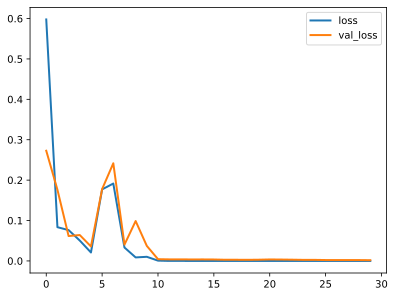

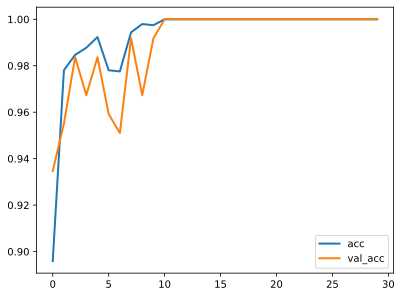

In [7]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [8]:
# x_train = []
# y_train = []
# x_train,y_train = next(train_generator)
x_test = []
y_test = []
x_test,y_test = next(validgen)

# for i in range(len(train_generator)-1):
#     x_train = np.append(x_train, train_generator[i+1][0], axis=0)
#     y_train = np.append(y_train, train_generator[i+1][1], axis=0)
for i in range(len(validgen)-1):
    x_test = np.append(x_test, validgen[i+1][0], axis=0)
    y_test = np.append(y_test, validgen[i+1][1], axis=0)
     


In [9]:
probs = model.predict(x_test)

2/2 [==============================] - 11s 3s/step


Precisão: 1.0


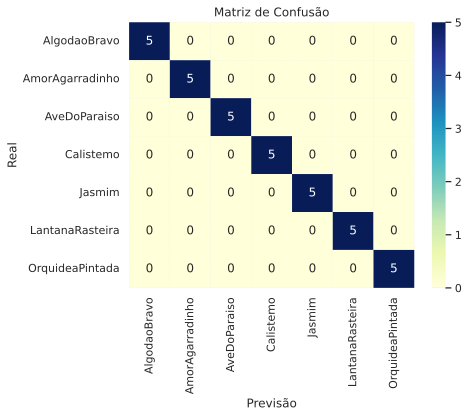

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = np.argmax(y_test, axis=1)

# Obter os nomes das classes
class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [11]:
x_test = []
y_test = []
x_test,y_test = next(testgen)

for i in range(len(testgen)-1):
    x_test = np.append(x_test, testgen[i+1][0], axis=0)
    y_test = np.append(y_test, testgen[i+1][1], axis=0)

In [12]:
probs = model.predict(x_test)

2/2 [==============================] - 0s 61ms/step


Precisão: 0.9428571428571428


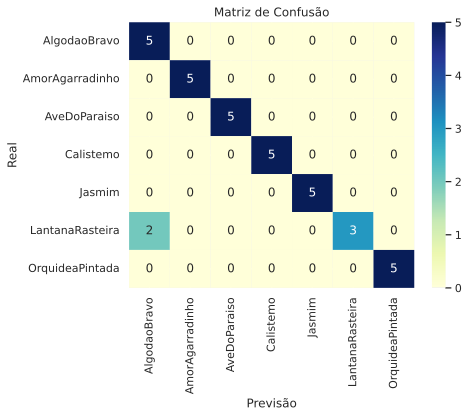

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = np.argmax(y_test, axis=1)

# Obter os nomes das classes
class_names = list(testgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 convnext_xlarge_prestem_normal  (None, 72, 72, 3)   0           ['input_1[0][0]']                
 ization (Normalization)                                                                          
                                                                                                  
 convnext_xlarge_stem (Sequenti  (None, None, None,   13056      ['convnext_xlarge_prestem_normali
 al)                            256)                             zation[0][0]']                   
                                                                                              